<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Laura/AML_IceCores_peruvian_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from Models import make_autoencoder, make_NN
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip
!pip install pyyaml h5py 
!pip install umap-learn
!pip install bayesian-optimization

! gdown --id 1FkB-wMHYzgK74-pek2H33DIpmfSOIxWc  # copy this line for peru data
! unzip Peru_data.zip                           # copy this line for peru data

Streaming af output blev afkortet til de sidste 5000 linjer.
 extracting: images/QCY/QCY_27_2_5_238.png  
 extracting: images/QCY/QCY_27_2_5_239.png  
 extracting: images/QCY/QCY_27_2_5_24.png  
 extracting: images/QCY/QCY_27_2_5_240.png  
 extracting: images/QCY/QCY_27_2_5_241.png  
 extracting: images/QCY/QCY_27_2_5_242.png  
 extracting: images/QCY/QCY_27_2_5_243.png  
 extracting: images/QCY/QCY_27_2_5_244.png  
 extracting: images/QCY/QCY_27_2_5_245.png  
 extracting: images/QCY/QCY_27_2_5_246.png  
 extracting: images/QCY/QCY_27_2_5_247.png  
 extracting: images/QCY/QCY_27_2_5_248.png  
 extracting: images/QCY/QCY_27_2_5_249.png  
 extracting: images/QCY/QCY_27_2_5_25.png  
 extracting: images/QCY/QCY_27_2_5_250.png  
 extracting: images/QCY/QCY_27_2_5_251.png  
 extracting: images/QCY/QCY_27_2_5_252.png  
 extracting: images/QCY/QCY_27_2_5_253.png  
 extracting: images/QCY/QCY_27_2_5_254.png  
 extracting: images/QCY/QCY_27_2_5_255.png  
 extracting: images/QCY/QCY_27_2_5_256.pn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
# copy this cell for peru data
peru_path = '/content/QCY.csv'
peru_im_path = '/content/images/QCY/'
peru_df = pd.read_csv(peru_path)
test = not_training_set(peru_df, peru_im_path, train.scaler) #peru

In [6]:
#train_size = len(train.labels)
test_size = len(test.imgpaths)

In [7]:
encoder = keras.models.load_model('encoder_128')

In [8]:
NN = keras.models.load_model('NN_scalar_encoder_128/NN_scalar_encoder_128')
NN_last_layer = keras.models.load_model('NN_last_layer_scalar_encoder_128')

In [9]:


increment = 5000
nr_its = test_size//increment
points_left_over = test_size % increment

list_of_encoded_images = []
#x_test_lab = []
x_test_feats = []
image_count = 0
for i in range(nr_its):
  x_test = []
  for j in range(increment):
      im, feat = test.__getitem__(image_count)
      image_count += 1
      x_test.append(im)
      #x_test_lab.append(lab)
      x_test_feats.append(feat)
  x_test = np.array(x_test)

  encoded = encoder.predict(x_test)

  list_of_encoded_images.extend(encoded)

x_test = []
for i in range(points_left_over):
  im, feat = test.__getitem__(image_count)
  image_count += 1
  x_test.append(im)
  #x_test_lab.append(lab)
  x_test_feats.append(feat)
x_test = np.array(x_test)

encoded = encoder.predict(x_test)

list_of_encoded_images.extend(encoded)

list_of_encoded_images = np.array(list_of_encoded_images)

x_test = []
for i in range(len(list_of_encoded_images)):
  one = np.append(x_test_feats[i], list_of_encoded_images[i])
  x_test.append(one)

x_test = np.array(x_test)
#x_test_lab = np.array(x_test_lab)

In [10]:
preds = np.argmax(NN.predict(x_test),axis=1)
#print(sum(preds==x_test)/len(x_test_lab)) # vi ved ikke hvor god den er så vi kan ikke sammenligne med noget. 

102764
[0 1 2 3 4 5 6 7]


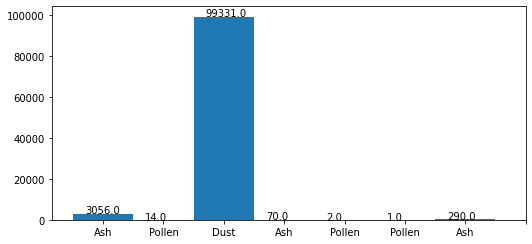

In [47]:

print(len(preds))


bars = ('Ash', 'Pollen', 'Dust','Ash',  'Pollen', 'Pollen', 'Ash')
x_pos =np.arange(8)

_, _, patches = plt.hist(preds,bins = x_pos, align="mid")
#plt.hist(preds, bins = x_pos)
for pp in patches:  
   x = (pp._x0 + pp._x1)/2 - .3
   y = pp._y1 + .05
   plt.text(x, y, pp._y1)
plt.xticks(x_pos+0.5,bars)
print(x_pos)

In [12]:
last_hidden = NN_last_layer.predict(x_test)
map =  umap.UMAP(n_components = 2, n_neighbors = 8, min_dist = 0.1)
y = map.fit_transform(last_hidden)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


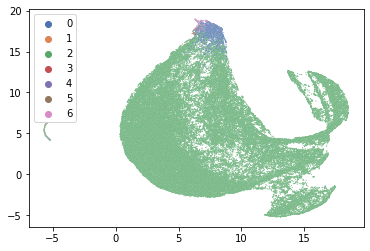

In [13]:
plt.figure()
sb.scatterplot(x = y[:,0],y = y[:,1], hue = preds, palette = 'deep', s=1)


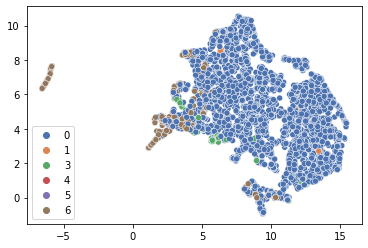

In [14]:


#last_hidden = NN_last_layer.predict()
map =  umap.UMAP(n_components = 2, n_neighbors = 8, min_dist = 0.1)
y2 = map.fit_transform(last_hidden[preds!=2])
plt.figure()
sb.scatterplot(x = y2[:,0],y = y2[:,1], hue = preds[preds!=2], palette = 'deep')


In [15]:
print(np.shape(last_hidden[preds!=2]))
np.shape(last_hidden)

(3433, 376)


(102764, 376)

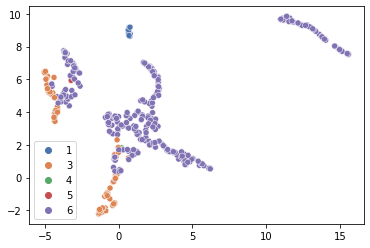

In [16]:


#last_hidden = NN_last_layer.predict()
map =  umap.UMAP(n_components = 2, n_neighbors = 8, min_dist = 0.1)
last_hidden_1 = last_hidden[preds!=2]
preds1 = preds[preds!=2]
y2 = map.fit_transform(last_hidden_1[preds[preds!=2]!=0])
plt.figure()
sb.scatterplot(x = y2[:,0],y = y2[:,1], hue = preds1[preds[preds!=2]!=0], palette = 'deep')


In [17]:
print(sum(preds==0))
print(sum(preds==1))
print(sum(preds==2))
print(sum(preds==3))
print(sum(preds==4))
print(sum(preds==5))
print(sum(preds==6))




3056
14
99331
70
2
1
290


3056.0
14.0
99331.0
70.0
2.0
1.0
290.0


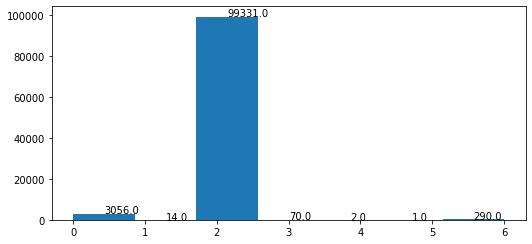

In [30]:
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

data = preds
_, _, patches = plt.hist(data,bins = 7, align="mid")

#for i in range(len(bars)):
  

for pp in patches:  
   print(pp._y1)  
   x = (pp._x0 + pp._x1)/2
   y = pp._y1 + 0.05
   plt.text(x, y, pp._y1)

plt.show()

In [25]:
patches

<a list of 10 Patch objects>